# Calibration of a non-linear dynamic model in a Bayesian framework

This is a simulation experiment: We only work with simulated data - meaning, that we create the "observations" from a simulation model itself.

The model we work with describes the growth of two populations, that interact with each other. It's similar to the Lotka-Volterra model but is based on the Ricker model. The Ricker model again is a version of the logistic growth. Even though it is a very simple model with only three parameters and one state variable, it has very complicated behaviour.
The two-species version of the Ricker model has a bit more parameters and two state variables. Further, the parameter for the growth rate is temperature dependent, meaning it depends on an exogeneous driver.

The final goal for your project is, to fit the Ricker model in a Bayesian framework in python. In the Advanced statistics class, we learned a bit about Bayesian Analysis (third week). Maybe you remember that I showed how to fit a Bayesian mixed effect model in the R brms package - but ALSO showed how this would model would look in Stan. Bayesian model calibration is generally better pursued using a probabilistic programming language, that has wide range of distributions and sampling algorithms implemented.

In Python, you have the option to work with a Stan interface to python: the pystan package. This is what you will be using. Introductory material to pystan is provided in the materials folder (Bayes_and_Stan).
Now, let's go stepwise through your project: What are the steps and what do I expect as results from you.

## Explore your model


What model are you working with?
What are the parameters and how does it behave if you modify them?
What do different sources of model uncertainty refer to?
How are model parameters structured, in a hierarchical sense?

These are just questions to guide you for a start with the mathematical model and how it links to the Bayesian perspective we started exploring in the class.

Now I am interested specifically in one question concerning the model before you start calibrating it:
What is the threshold for lambda (in the multispecies and temperature dependent Ricker model: lambda_x and lambda_y) from which on the model behaviour becomes chaotic?

Your first task is to find this out.
The results, I expect:
 1. Implementation of a pipeline that takes the derivative of the multi-species ricker model (both, with exogeneous variables and without).
 2. A line-plot with lambda on the x-axis and the Lyapunov exponent on the y-axis, showing the relationship between the growth rate and the exponent for both species **with** uncertainties.

How to do this? Follow the example in the subsection below and use the Jypyter notebook in the material/numerical_differentiation folder and my Github repository (https://github.com/MWesselkamp/Ricker/models.py, functions: *derive_model*, *model_torch*).

### Detecting chaotic behaviour

The Lyapunov exponent is a property of a function that gives information on the function regime, if it is chaotic or non-chaotic. We can compute it from the first derivative of the model.
For the Single-Species Ricker without temperature dependence, our knowledge of high-school calculus might be sufficient to find the derivative in closed form. However, if we pick one of the more complex models, we will get to our precision limits. So let's use the torch.autograd package to find the numerical derivative (based on: autograd_grad_griesler.jpynb).

In [13]:
import simulations # from Mariekes code
import numpy as np
import torch
from torch.autograd import grad

At the example of the Single-species model we just specified, let's the define the function we want to derive.
$N_{t+1} =  N e^{\lambda(1-\alpha N)}  =  N e^{r} {e^{1-\alpha N}$. If we are in a chaotic or non-chaotic regime depends on the parameter $\lambda$ that represents the exponential of the growth rate and that is defined as $\lambda = e^{r}$. $\alpha$ is the inverse of the carrying capacity, as such $\alpha = 1/k$.
First, the model parameters that were used for the above simulation we choose manually.


In [14]:
def f(N, r= 1.9, k=20):
    return torch.exp(torch.tensor(r)) * N * torch.exp(- 1/k * N)

The points that we want to take the derivative at, we just simulated. Let's use only one ensemble member for now.
Two things are here to note: We can use grad only to if $f(N)$ returns a scalar (in form of a tensor), and if every variable is contained in the graph. That means, we have to calculate the derivative of the vector stepwise for every element.

Now, for the single-species Ricker model, the numerical derivation is already implemented. Let's compute it as an example

SIMULATION UNDER THE FOLLOWING CONDITIONS:
Type of Ricker Model that will be used:    single-species
Simulation from Ricker in the following regime:   non-chaotic
Exogeneous impact on state variable considered?    exogeneous
UNCERTAINTIES CONSIDERED:
Consider parameter uncertainty:       False
Consider initial condition uncertainty:       True
Consider process uncertainty, i.e. NOT deterministic:     True


/Users/Marieke_Wesselkamp/PycharmProjects/Ricker/models.py:154: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


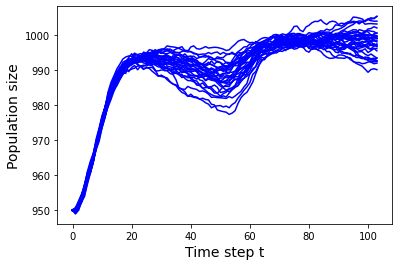

In [15]:
sims = simulations.Simulator(model_type="single-species",
                             simulation_regime="non-chaotic",
                             environment="exogeneous")
sims.hyper_parameters(simulated_years=2,
                           ensemble_size=30,
                           initial_size=950)
xsim = sims.simulate()
mod = sims.ricker
xsim_derivative = mod.derive(xsim)

Look into the code of models to see, how the implementation looks like.
Now that we know how to derive a model, how to we calculate the Lyapunov exponent from it?

In [16]:
def lyapunov(x):
    '''
    Calculate the Lyapunov exponent of the function f(N) that has been evolved for a known N_start.
    '''
    df_dN = []
    for i in range(x.shape[1]): # stepwise derivative
        N = x[:, i]
        N = torch.tensor(N, requires_grad=True) # set requires_grad = True for computing the gradient
        dN = grad(f(N), N)
        df_dN.append(torch.tensor(dN)) # turn tuple into tensor
    df_dN = torch.cat(df_dN).detach().numpy()

    return np.mean(np.log(abs(df_dN)))

xs = xsim[np.random.choice(np.arange(xsim.shape[0]), 1), :] # pick a random ensemble member
print(lyapunov(xs)) # compute lyapunov exponent for this member

-43.55624984938642


In the above example we calculate the exponent only of one of the trajectories we simulated. If we do this for all trajectories (i.e. ensemble members), we get the uncertainty of our exponent. Now for the derivative of the multi-species model, you can just take separately for both species.

## Fit your model in Pystan

This is the main goal of your project. Find the parameters for the multispecies Ricker, that best fit your simulated data.
The results I expect: A pipeline, from the structure very similar to materials/Bayes_and_Stan/07 - Temporal models - Part 3 - STAN..jpynb. Plots of the posterior distributions of the parameters.

2. Simulate data from the multi-species Ricker Model with exongeneous variable. You need fix parameters to do so. Use values for lambda_x and lambda_y in the non-chaotic regime!
3. You want to fit the multispecies Ricker model, where we don't consider temperature dependency of the lambdas with pystan.
    - specify your model in pystan (based on materials/Bayes_and_Stan/...)
    - start simple: first, simply use a distribution to model the data. Then, use the single species model. Last, implement the multispecies model.
4. Fit the model and plot the posterior distributions of the parameters.


You will have to make choices on the priors you use for simulations and the likelihood function you will be optimizing.